# CS166 Assignment 2: Traffic simulation

#### Dennis Kageni
#### Spring 2020


In this assignment, you will build cellular automata to model traffic flow.

Each cell is about the size of a car and cars travel along a road, passing other cars if they can. You will see how cellular automata can be used to model some realistic traffic patterns and explore what happens if driver behavior changes.


### Part 1 - Traffic Jams on a Circular Road
Implement the single lane, variable speed traffic model described in Nagel, K., Schreckenberg, M. (1992).

* Write well-structured and well-documented Python code to implement the model described in the paper.
* Visualize the state of this model over time, to show how traffic jams can appear when traffic density is high enough.
* Analyze how the overall average traffic flow rate varies with traffic density and present your results in your report.

### Part 2 - Multi-lane Highways
Implement the 2-lane, symmetric, uni-directional, variable speed model in Rickert, M., et al. (1996).

* A description, in your report, of how this model works. What are the assumptions, parameters, and update rules of the model? Do not just copy and paste from the paper. Explain the cellular automaton in your own words and as clearly as possible.
* Write well-structured and well-documented Python code to implement the model described in the paper.
* Visualize the state of this model over time, to show the typical traffic patterns that can emerge. Your results will again depend on traffic density.
* Analyze how much more traffic can flow through a multi-lane road, compare to a single lane road, at the same traffic density. Present your results in your report.


### Key Questions
* How much more traffic can flow through a 2-lane road compared to a 1-lane road at the same traffic density? What about roads with more than 2 lanes? Either model 3 or more lanes and report on your results, or predict how much larger the traffic flow through a 3+ lane road will be compared to a 1-lane road at the same traffic density.
* How applicable is this model to traffic in your city? Write a short paragraph and motivate why the model is suited to traffic in your city (or why it is not).

In [1]:
# import required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

### Part 1 - Traffic Jams on a Circular Road

In [2]:
class TrafficSimulation():
    
    def __init__(self, length = 100, car_density = 0.3, slow_down_prob = 0.5, max_speed = 5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.3.

            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.length = length # number of cells in the road
        self.car_density = car_density # fraction of cells that have a car on them
        self.max_speed = max_speed # maximum speed in car cells per update step
        self.slow_down_prob = slow_down_prob # probability that a car will randomly slow down by 1 during an update step
        
        self.flow = 0 # Flow counter to track the number of cars exiting the road on the left side after 
                      # each time step.
        
        # Initialize lane 1; place cars on random index; initialize cars at random velocities
        self.lane_one = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        random_idx = np.random.choice(range(self.length), size=int(round(car_density * self.length)), replace=False)
        self.lane_one[random_idx] = np.random.randint(0, self.max_speed + 1, size=len(random_idx))
        
        # Track the time steps and total number of cars that passed the simulation boundary 
        # to estimate average traffic flow.
        
        self.time_step = 0
        self.cumulative_traffic_flow = 0
            
    
    def step(self, display = True):
        """
        Method to update car velocities
        
        We implement the following rules
        - acceleration
        - deceleration
        - random slow down
        """
        
        # looping through cars in the lane
        for i in range(self.length):
            if self.lane_one[i] != -1: # if there is a car in the cell
                dist = 0 
                while self.lane_one[(i + (dist + 1)) % self.length] == -1:
                        dist += 1
                # accelerate
                if dist > self.lane_one[i] and self.lane_one[i] < self.max_speed: 
                    self.lane_one[i] += 1 
                # decelerate
                if dist < self.lane_one[i]: 
                    self.lane_one[i] = dist
                # slow down at random
                if self.lane_one[i] > 0 and np.random.random() < self.slow_down_prob:
                    self.lane_one[i] -= 1                   
        
        # Here, we loop through updated velocities and move the cars to their new positions
        lane_one_next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.lane_one[i] != -1:
                lane_one_next_state[(i + self.lane_one[i]) % self.length] = self.lane_one[i]
        self.lane_one = lane_one_next_state  
        
        
        self.time_step += 1 # update time-step
        #update traffic-flow
        for i in range(self.max_speed):
            if self.lane_one[i] > i:
                self.cumulative_traffic_flow += 1

        if display:
            self.display()
    
    def display(self):
        """
        Method to print our the current state of the simulation
        """
        print(''.join('.' if x == -1 else str(x) for x in self.lane_one))
        
sim = TrafficSimulation()
for i in range(25): # observe the next 25 time steps
    sim.step()  

0..1.0...2...000......4..............4....30.1..1.0...10...2..1.....5..2..00...3.1....4..2....000.1.
0..0..1.....300.1.........4.............3.0.1.1.0.0...0.1...1..1.....1..1.00....1.1.....2...3.00.10.
0..0...1....00.1.1.............5.........10..10..10...0...2...2.1......2.100....0...2......3.10.100.
0..0....1...00.0..1.................5....0.1.00..0.1...1....2.0...2....0.000....0.....2.....10.1000.
.1.0......2.00.0...1....................40.0.0.1.0...2...2...10......3.0.000....0.......2...00.000.1
1.10......0.00.0....1...................00..1.1.10.....2...2.00.......1.1000.....1........2.0.1000..
.100.......10.1.1....1..................00...1.100.......2..100........1000.1......2.......10.0000..
.00.1......0.1.1..2...1.................0.1..0.000........1.00.1.......000.1..2.......3....00.0000..
.0.1.1......10...2..2...2................1..2.1000.........10.1..2.....00.1..2...3........400.0000..
.0..1..2....0.1....2..2....3...............20.0000.........0.1.1...2...00..1...2.....4....0

In [3]:
sim = TrafficSimulation(car_density = 0.01)
for i in range(25): # observe the next 25 time steps
    sim.step()

.........................................0..........................................................
.........................................0..........................................................
.........................................0..........................................................
..........................................1.........................................................
...........................................1........................................................
............................................1.......................................................
.............................................1......................................................
..............................................1.....................................................
...............................................1....................................................
.................................................2.........................................

In [4]:
#___________________________
# SINGLE LANE SIMULATION
#___________________________

one_lane_traffic_flow = []
one_lane_traffic_density = []

for el in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05))):
        one_lane_traffic_density.append(el)
        one_lane_traffic_flow.append([])
        for run in range(10):
            sim = TrafficSimulation(car_density = el)
            for i in range(50):
                sim.step(display=False)
            one_lane_traffic_flow[-1].append(sim.cumulative_traffic_flow / sim.time_step)

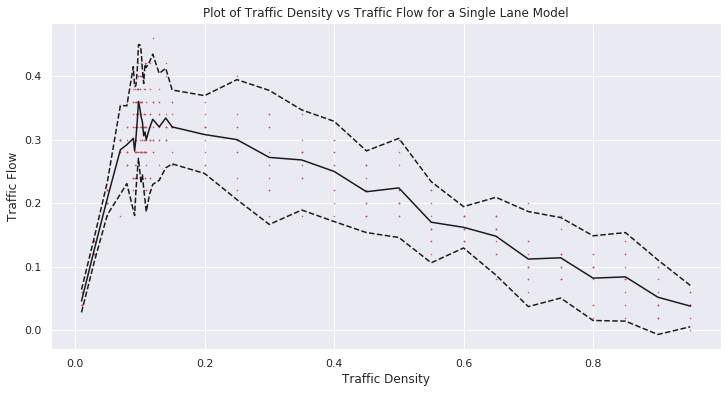

In [5]:
#___________________________________________________
# PLOTTING THE DENSITY OF THE SINGLE LANE SIMULATION
#___________________________________________________

avg = np.mean(np.array(one_lane_traffic_flow), axis=1)
std_dev = np.std(np.array(one_lane_traffic_flow), axis=1)


plt.figure(figsize=(12, 6))
plt.plot(one_lane_traffic_density, one_lane_traffic_flow, 'r.', markersize = 1)
plt.plot(one_lane_traffic_density, avg, 'k-')
plt.plot(one_lane_traffic_density, avg + 1.96*std_dev, 'k--')
plt.plot(one_lane_traffic_density, avg - 1.96*std_dev, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.title('Plot of Traffic Density vs Traffic Flow for a Single Lane Model')
plt.show()

### Part 2 - Multi-lane Highways
#### Two lane road

In [6]:
class TwoLaneTrafficSimulation():
    def __init__(self, length = 100, car_density = 0.3, max_speed = 5, slow_down_prob = 0.5, switch_lane_prob = 1):
        """
        Traffic simulation object for Two Lanes. Identical to the `TrafficSimulation` class above
        with the only exception being we have added a new variable switch_lane_prob
        
        Inputs:

            length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.3.

            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
              
            switch_lane_prob (int) The probability of a car switching lanes when
                conditions allow. 
                Default: 1
        """
        
        self.length = length 
        self.car_density = car_density 
        self.max_speed = max_speed 
        self.slow_down_prob = slow_down_prob 
        self.switch_lane_prob = switch_lane_prob # The probability of switching lanes
        
        # Initialize lane 1; place cars on random index; initialize cars at random velocities
        self.lane_one = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        random_idx = np.random.choice(range(self.length), size=int(round((car_density * self.length))), replace=False)
        self.lane_one[random_idx] = np.random.randint(0, self.max_speed + 1, size=len(random_idx))
        
        # Initialize lane 2; place cars on random index; initialize cars at random velocities
        self.lane_two = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        random_idx = np.random.choice(range(self.length), size=int(round(car_density * self.length)), replace=False)
        self.lane_two[random_idx] = np.random.randint(0, self.max_speed + 1, size=len(random_idx))

        '''Track the time steps and total number of cars that passed the simulation boundary 
        to estimate average traffic flow.'''
        self.time_step = 0
        self.cumulative_traffic_flow = 0
    
    
    def step(self, display = True):                
        
        self.orig_lane_one = self.lane_one.copy()
        self.orig_lane_two = self.lane_two.copy()

        for i in range(self.length):
            
            # encoding lane changing behavior rule set for lane one
            if self.lane_one[i] != -1: # if there's a car in the cell
                
                front_dist_lane_one = 0
                front_dist_lane_two = 0
                back_dist_lane_two = 0
                
                while self.lane_one[(i + (front_dist_lane_one + 1)) % self.length] == -1:
                    front_dist_lane_one += 1
                while self.lane_two[(i + (front_dist_lane_two + 1)) % self.length] == -1:
                    front_dist_lane_two += 1
                while self.lane_two[(i - (back_dist_lane_two + 1)) % self.length] == -1:
                    back_dist_lane_two +=1
                
                if self.lane_one[i] == self.max_speed:
                    if front_dist_lane_one < self.lane_one[i] and self.lane_two[i] == -1 and front_dist_lane_two >= self.lane_one[i] and back_dist_lane_two >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_two[i] = self.lane_one[i]
                        self.lane_one[i] = -1
                
                elif self.lane_one[i] < self.max_speed and self.lane_one[i] > 0:
                    if front_dist_lane_one < self.lane_one[i]+1 and self.lane_two[i] == -1 and front_dist_lane_two >= self.lane_one[i]+1 and back_dist_lane_two >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_two[i] = self.lane_one[i]
                        self.lane_one[i] = -1

                elif self.lane_one[i] == 0:
                    if front_dist_lane_one < self.lane_one[i]+1 and self.lane_two[i] == -1 and front_dist_lane_two >= self.lane_one[i]+1 and back_dist_lane_two >= self.max_speed and np.random.random() < self.switch_lane_prob:
                        self.lane_two[i] = self.lane_one[i]
                        self.lane_one[i] = -1
            
                        
            # encoding lane changing behavior rule set for lane two
            if self.orig_lane_two[i] != -1: 
                
                front_dist_lane_two = 0
                front_dist_lane_one = 0
                back_dist_lane_one = 0
               
                while self.orig_lane_two[(i + (front_dist_lane_two + 1)) % self.length] == -1:
                    front_dist_lane_two += 1
                while self.lane_one[(i + (front_dist_lane_one + 1)) % self.length] == -1:
                    front_dist_lane_one += 1
                while self.lane_one[(i - (back_dist_lane_one + 1)) % self.length] == -1:
                    back_dist_lane_one += 1
                
                if self.orig_lane_two[i] == self.max_speed:
                    if front_dist_lane_two < self.orig_lane_two[i] and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_two[i] and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_two[i]
                        self.lane_two[i] = -1
                
                elif self.orig_lane_two[i] < self.max_speed and self.orig_lane_two[i] > 0:
                    if front_dist_lane_two < self.orig_lane_two[i]+1 and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_two[i]+1 and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_two[i]
                        self.lane_two[i] = -1

                elif self.orig_lane_two[i] == 0:
                    if front_dist_lane_two < self.orig_lane_two[i]+1 and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_two[i]+1 and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_two[i]
                        self.lane_two[i] = -1

            
            # speed change rules for lane one
            if self.lane_one[i] != -1: 
                dist = 0 
                while self.lane_one[(i + (dist + 1)) % self.length] == -1:
                    dist += 1
                if dist > self.lane_one[i] and self.lane_one[i] < self.max_speed:
                    self.lane_one[i] += 1
                if dist < self.lane_one[i]:
                    self.lane_one[i] = dist 
                if self.lane_one[i] > 0 and np.random.random() < self.slow_down_prob:
                    self.lane_one[i] -= 1    
            
            # speed change rules for lane one
            if self.lane_two[i] != -1:
                dist_other = 0
                while self.lane_two[(i + (dist_other + 1)) % self.length] == -1:
                    dist_other += 1
                if dist_other > self.lane_two[i] and self.lane_two[i] < self.max_speed:
                    self.lane_two[i] += 1
                if dist_other < self.lane_two[i]:
                    self.lane_two[i] = dist_other 
                if self.lane_two[i] > 0 and np.random.random() < self.slow_down_prob:
                    self.lane_two[i] -= 1 
        
        # the car motion rule
        lane_one_next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.lane_one[i] != -1:
                lane_one_next_state[(i + self.lane_one[i]) % self.length] = self.lane_one[i]
        self.lane_one = lane_one_next_state  
        
        lane_two_next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.lane_two[i] != -1:
                lane_two_next_state[(i + self.lane_two[i]) % self.length] = self.lane_two[i]
        self.lane_two = lane_two_next_state
        
        
        # update time and traffic flows
        self.time_step += 1
        for i in range(self.max_speed):
            if self.lane_one[i] > i:
                self.cumulative_traffic_flow += 1
            if self.lane_two[i] > i:
                self.cumulative_traffic_flow += 1
        
        
        '''Display the function'''
        if display:
            self.display()
                    

    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.lane_one))
        print(''.join('.' if x == -1 else str(x) for x in self.lane_two))
        print('') 
  
sim = TwoLaneTrafficSimulation()
sim.display()
for i in range(30):
    sim.step()  

1.......3...5..5........153..30..4...0........040.....232........2233.........4......3.025..31..2.0.
..........3...12..4...3...4.3..14..4..0.5.....2...4.2..2.5...1...3..........02.0.2....32.5..5..21.3.

.1.........3.1.....4....00..20.1...2..1.......00.1....00..2......000...3....0.....4..0.00.1.0..2.1.1
..4.........2.0.1....3..2.0...20..2.1..1....4....30...20...2..1......4........10...2..0.1..2.1.0.1..

1.1........0..1........400..00..1....2.1......0.1..2..00....2....00.1......4.1......2.10.1.10...10..
......4......10...2....2.1.1..0.1.0...2..2.....3.00...0.1...1...2........4....0.1...1.0...20..10...2

.1.1........1...2......000..0.1...2...1..2....0...2..20.1......3.00...2....0...2.....100.0.00...00..
..3........5.0.1.....3..1.1..2.1.1.1....2...3...10.1..0..1....2...2..........40..1...1.1..0.1.0.1...

..1.1.........2....3...00.1..1..2....3.1...2..0.....20.1..2.....10.1....2..0......3..00.10.0.1..0.1.
.....3......1.1..2....1.0..1..1.10...2....2...2.00..1..1..1.....2....3.......00....2..1

In [7]:
#___________________________
# TWO LANE SIMULATION
#___________________________

two_lane_traffic_flow = []
two_lane_traffic_density = []
for el in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05)
)):
    two_lane_traffic_density.append(el)
    two_lane_traffic_flow.append([])
    for run in range(10):
        sim = TwoLaneTrafficSimulation(car_density=el)
        for i in range(50):
            sim.step(display=False)
        two_lane_traffic_flow[-1].append(sim.cumulative_traffic_flow / sim.time_step)

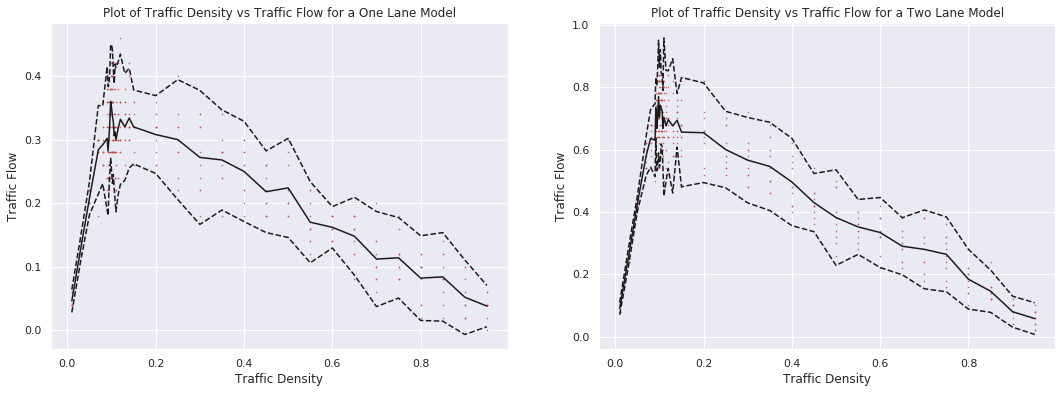

In [8]:
#___________________________________________________
# PLOTTING THE DENSITY OF THE TWO LANE SIMULATION
#___________________________________________________

avg_twolane = np.mean(np.array(two_lane_traffic_flow), axis=1)
std_dev_twolane = np.std(np.array(two_lane_traffic_flow), axis=1)
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.plot(one_lane_traffic_density, one_lane_traffic_flow, 'r.', markersize = 1)
plt.plot(one_lane_traffic_density, avg, 'k-')
plt.plot(one_lane_traffic_density, avg + 1.96*std_dev, 'k--')
plt.plot(one_lane_traffic_density, avg - 1.96*std_dev, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.title('Plot of Traffic Density vs Traffic Flow for a One Lane Model')

plt.subplot(1,2,2)
plt.plot(two_lane_traffic_density, two_lane_traffic_flow, 'r.', markersize=1)
plt.plot(two_lane_traffic_density, avg_twolane, 'k-')
plt.plot(two_lane_traffic_density, avg_twolane + 1.96*std_dev_twolane, 'k--')
plt.plot(two_lane_traffic_density, avg_twolane - 1.96*std_dev_twolane, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.title('Plot of Traffic Density vs Traffic Flow for a Two Lane Model')
plt.show()

#### Three lane road

In [9]:
class ThreeLaneTrafficSimulation():
    def __init__(self, length = 100, car_density = 0.3, max_speed = 5, slow_down_prob = 0.5, switch_lane_prob = 1):
        """
        Traffic simulation object for Two Lanes. Identical to the `TwoTrafficSimulation` class above
        with the only exception being we have added another lane
        
        Inputs:

            length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.3.

            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
              
            switch_lane_prob (int) The probability of a car switching lanes when
                conditions allow. 
                Default: 1
        """
        
        self.length = length 
        self.car_density = car_density 
        self.max_speed = max_speed 
        self.slow_down_prob = slow_down_prob 
        self.switch_lane_prob = switch_lane_prob # The probability of switching lanes
        
        # Initialize lane 1; this will be the middle lane
        self.lane_one = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        random_idx = np.random.choice(range(self.length), size=int(round((car_density * self.length))), replace=False)
        self.lane_one[random_idx] = np.random.randint(0, self.max_speed + 1, size=len(random_idx))
        
        # Initialize lane 2; 
        self.lane_two = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        random_idx = np.random.choice(range(self.length), size=int(round(car_density * self.length)), replace=False)
        self.lane_two[random_idx] = np.random.randint(0, self.max_speed + 1, size=len(random_idx))
        
        # Initialize lane 3. 
        self.lane_three = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        random_idx = np.random.choice(range(self.length), size=int(round(car_density * self.length)), replace=False)
        self.lane_three[random_idx] = np.random.randint(0, self.max_speed + 1, size=len(random_idx))

        '''Track the time steps and total number of cars that passed the simulation boundary 
        to estimate average traffic flow.'''
        self.time_step = 0
        self.cumulative_traffic_flow = 0
    
    
    def step(self, display = True):                
        
        self.orig_lane_one = self.lane_one.copy()
        self.orig_lane_two = self.lane_two.copy()
        self.orig_lane_three = self.lane_three.copy()

        for i in range(self.length):
            
            # encoding lane changing behavior rule set for lane one
            if self.lane_one[i] != -1: # if there's a car in the cell
            
                front_dist_lane_one = 0
                front_dist_lane_two = 0
                back_dist_lane_two = 0
                front_dist_lane_three = 0
                back_dist_lane_three = 0
                
                
                while self.lane_one[(i + (front_dist_lane_one + 1)) % self.length] == -1:
                    front_dist_lane_one += 1
                while self.lane_two[(i + (front_dist_lane_two + 1)) % self.length] == -1:
                    front_dist_lane_two += 1
                while self.lane_two[(i - (back_dist_lane_two + 1)) % self.length] == -1:
                    back_dist_lane_two +=1
                while self.lane_three[(i + (front_dist_lane_three + 1)) % self.length] == -1:
                    front_dist_lane_three += 1
                while self.lane_three[(i - (back_dist_lane_three + 1)) % self.length] == -1:
                    back_dist_lane_three +=1
                
                
                if self.lane_one[i] == self.max_speed:
                    if front_dist_lane_one < self.lane_one[i] and self.lane_two[i] == -1 and front_dist_lane_two >= self.lane_one[i] and back_dist_lane_two >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_two[i] = self.lane_one[i]
                        self.lane_one[i] = -1
                    elif front_dist_lane_one < self.lane_one[i] and self.lane_three[i] == -1 and front_dist_lane_three >= self.lane_one[i] and back_dist_lane_three >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_three[i] = self.lane_one[i]
                        self.lane_one[i] = -1
                        
                elif self.lane_one[i] < self.max_speed and self.lane_one[i] > 0:
                    if front_dist_lane_one < self.lane_one[i]+1 and self.lane_two[i] == -1 and front_dist_lane_two >= self.lane_one[i]+1 and back_dist_lane_two >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_two[i] = self.lane_one[i]
                        self.lane_one[i] = -1
                    elif front_dist_lane_one < self.lane_one[i]+1 and self.lane_three[i] == -1 and front_dist_lane_three >= self.lane_one[i]+1 and back_dist_lane_three >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_three[i] = self.lane_one[i]
                        self.lane_one[i] = -1
                        

                elif self.lane_one[i] == 0:
                    if front_dist_lane_one < self.lane_one[i]+1 and self.lane_two[i] == -1 and front_dist_lane_two >= self.lane_one[i]+1 and back_dist_lane_two >= self.max_speed and np.random.random() < self.switch_lane_prob:
                        self.lane_two[i] = self.lane_one[i]
                        self.lane_one[i] = -1
                    ## Looks at brother lane ##
                    elif front_dist_lane_one < self.lane_one[i]+1 and self.lane_three[i] == -1 and front_dist_lane_three >= self.lane_one[i]+1 and back_dist_lane_three >= self.max_speed and np.random.random() < self.switch_lane_prob:
                        self.lane_three[i] = self.lane_one[i]
                        self.lane_one[i] = -1
                        
            
                        
            # encoding lane changing behavior rule set for lane two
            if self.orig_lane_two[i] != -1: 
                
                front_dist_lane_two = 0
                front_dist_lane_one = 0
                back_dist_lane_one = 0
                
               
                while self.orig_lane_two[(i + (front_dist_lane_two + 1)) % self.length] == -1:
                    front_dist_lane_two += 1
                while self.lane_one[(i + (front_dist_lane_one + 1)) % self.length] == -1:
                    front_dist_lane_one += 1
                while self.lane_one[(i - (back_dist_lane_one + 1)) % self.length] == -1:
                    back_dist_lane_one += 1
                
                if self.orig_lane_two[i] == self.max_speed:
                    if front_dist_lane_two < self.orig_lane_two[i] and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_two[i] and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_two[i]
                        self.lane_two[i] = -1
                
                elif self.orig_lane_two[i] < self.max_speed and self.orig_lane_two[i] > 0:
                    if front_dist_lane_two < self.orig_lane_two[i]+1 and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_two[i]+1 and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_two[i]
                        self.lane_two[i] = -1

                elif self.orig_lane_two[i] == 0:
                    if front_dist_lane_two < self.orig_lane_two[i]+1 and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_two[i]+1 and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_two[i]
                        self.lane_two[i] = -1
            
            # encoding lane changing behavior rule set for lane two
            if self.orig_lane_three[i] != -1: 
                
                front_dist_lane_three = 0
                front_dist_lane_one = 0
                back_dist_lane_one = 0
               
                while self.orig_lane_three[(i + (front_dist_lane_three + 1)) % self.length] == -1:
                    front_dist_lane_three += 1
                while self.lane_one[(i + (front_dist_lane_one + 1)) % self.length] == -1:
                    front_dist_lane_one += 1
                while self.lane_one[(i - (back_dist_lane_one + 1)) % self.length] == -1:
                    back_dist_lane_one += 1
                
                if self.orig_lane_three[i] == self.max_speed:
                    if front_dist_lane_three < self.orig_lane_three[i] and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_three[i] and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_three[i]
                        self.lane_three[i] = -1
                
                elif self.orig_lane_three[i] < self.max_speed and self.orig_lane_three[i] > 0:
                    if front_dist_lane_three < self.orig_lane_three[i]+1 and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_three[i]+1 and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_three[i]
                        self.lane_three[i] = -1

                elif self.orig_lane_three[i] == 0:
                    if front_dist_lane_three < self.orig_lane_three[i]+1 and self.lane_one[i] == -1 and front_dist_lane_one >= self.orig_lane_three[i]+1 and back_dist_lane_one >= self.max_speed and np.random.random() < self.switch_lane_prob: 
                        self.lane_one[i] = self.orig_lane_three[i]
                        self.lane_three[i] = -1

            
            # speed change rules for lane one
            if self.lane_one[i] != -1: 
                dist = 0 
                while self.lane_one[(i + (dist + 1)) % self.length] == -1:
                    dist += 1
                if dist > self.lane_one[i] and self.lane_one[i] < self.max_speed:
                    self.lane_one[i] += 1
                if dist < self.lane_one[i]:
                    self.lane_one[i] = dist 
                if self.lane_one[i] > 0 and np.random.random() < self.slow_down_prob:
                    self.lane_one[i] -= 1    
            
            # speed change rules for lane two
            if self.lane_two[i] != -1:
                dist_two = 0
                while self.lane_two[(i + (dist_two + 1)) % self.length] == -1:
                    dist_two += 1
                if dist_two > self.lane_two[i] and self.lane_two[i] < self.max_speed:
                    self.lane_two[i] += 1
                if dist_two < self.lane_two[i]:
                    self.lane_two[i] = dist_two 
                if self.lane_two[i] > 0 and np.random.random() < self.slow_down_prob:
                    self.lane_two[i] -= 1 
                    
            # speed change rules for lane two
            if self.lane_three[i] != -1:
                dist_three = 0
                while self.lane_three[(i + (dist_three + 1)) % self.length] == -1:
                    dist_three += 1
                if dist_three > self.lane_three[i] and self.lane_three[i] < self.max_speed:
                    self.lane_three[i] += 1
                if dist_three < self.lane_three[i]:
                    self.lane_three[i] = dist_three
                if self.lane_three[i] > 0 and np.random.random() < self.slow_down_prob:
                    self.lane_three[i] -= 1
        
        # the car motion rule
        lane_one_next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.lane_one[i] != -1:
                lane_one_next_state[(i + self.lane_one[i]) % self.length] = self.lane_one[i]
        self.lane_one = lane_one_next_state  
        
        lane_two_next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.lane_two[i] != -1:
                lane_two_next_state[(i + self.lane_two[i]) % self.length] = self.lane_two[i]
        self.lane_two = lane_two_next_state
        
        
        lane_three_next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.lane_three[i] != -1:
                lane_three_next_state[(i + self.lane_three[i]) % self.length] = self.lane_three[i]
        self.lane_three = lane_three_next_state
        
        
        # update time and traffic flows
        self.time_step += 1
        for i in range(self.max_speed):
            if self.lane_one[i] > i:
                self.cumulative_traffic_flow += 1
            if self.lane_two[i] > i:
                self.cumulative_traffic_flow += 1
            if self.lane_three[i] > i:
                self.cumulative_traffic_flow += 1
        
        
        '''Display the function'''
        if display:
            self.display()
                    

    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.lane_one))
        print(''.join('.' if x == -1 else str(x) for x in self.lane_two))
        print(''.join('.' if x == -1 else str(x) for x in self.lane_three))
        print('') #separate between two different time steps
  
sim = ThreeLaneTrafficSimulation()
sim.display()
for i in range(30):
    sim.step()  

.015......0..5.15...050...5.......0.4.1.............5.........3.1.345..4...1.....0.1..5..10..3...11.
.21.0..0..0.3..3......1....4..1...2......3...1..1...51...4.1.231...0...25.......0..1....2.35.......1
........25...2.0..1.0....4...2.0....2...2.0.4..5.1...........52.5.21.035..3....1.......40.0....52...

20.....4...1..10...300.1......4....10...2........5.......5...2.10.00..2...3.1.....1.1...20.1...2.0..
.00.0...1..1..2....4...1....1..1....2.......3.1...2.0.1..0...00..2.0...0.....5...1..1...0.0....4...0
....2...0...3.10..0.0......2.0..1.....2..10.....1.1..........00.0.00.00..2....4..2.....00.0....0...3

00........3.1.0.1..000...2........400.....2..........4.....2..10.100.....3.1..2....1.1..00..1...1.1.
100..1...1...2...3....3..2....2.1......3....0...2..10..1.0...0.1..10....1.......3.1...2.0.0.......3.
...4...30...0.0.1..1.1.....0..1...2....1.00......1.1.........00..10.100.....3..1...2...0.1.1...0....

0.1.......0..10..1.000......3.....00.1......2.....2......4..1.00.000......1..2..2..0...2

In [10]:
#___________________________
# THREE LANE SIMULATION
#___________________________

three_lane_traffic_flow = []
three_lane_traffic_density = []
for el in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05)
)):
    three_lane_traffic_density.append(el)
    three_lane_traffic_flow.append([])
    for run in range(10):
        sim = ThreeLaneTrafficSimulation(car_density=el)
        for i in range(50):
            sim.step(display=False)
        three_lane_traffic_flow[-1].append(sim.cumulative_traffic_flow / sim.time_step)

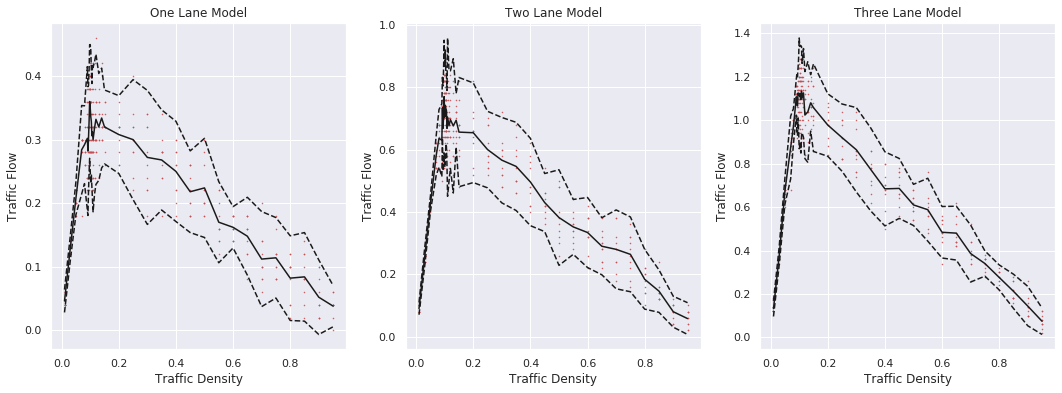

In [11]:
#___________________________________________________
# PLOTTING THE DENSITY OF THE THREE LANE SIMULATION
#___________________________________________________

avg_threelane = np.mean(np.array(three_lane_traffic_flow), axis=1)
std_dev_threelane = np.std(np.array(three_lane_traffic_flow), axis=1)
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
plt.plot(one_lane_traffic_density, one_lane_traffic_flow, 'r.', markersize = 1)
plt.plot(one_lane_traffic_density, avg, 'k-')
plt.plot(one_lane_traffic_density, avg + 1.96*std_dev, 'k--')
plt.plot(one_lane_traffic_density, avg - 1.96*std_dev, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.title('One Lane Model')

plt.subplot(1,3,2)
plt.plot(two_lane_traffic_density, two_lane_traffic_flow, 'r.', markersize=1)
plt.plot(two_lane_traffic_density, avg_twolane, 'k-')
plt.plot(two_lane_traffic_density, avg_twolane + 1.96*std_dev_twolane, 'k--')
plt.plot(two_lane_traffic_density, avg_twolane - 1.96*std_dev_twolane, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.title('Two Lane Model')

plt.subplot(1,3,3)
plt.plot(three_lane_traffic_density, three_lane_traffic_flow, 'r.', markersize=1)
plt.plot(three_lane_traffic_density, avg_threelane, 'k-')
plt.plot(three_lane_traffic_density, avg_threelane + 1.96*std_dev_threelane, 'k--')
plt.plot(three_lane_traffic_density, avg_threelane - 1.96*std_dev_threelane, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.title('Three Lane Model')
plt.show()

## Visualization to observe the effect of adding lanes to Traffic Flow and Traffic Density

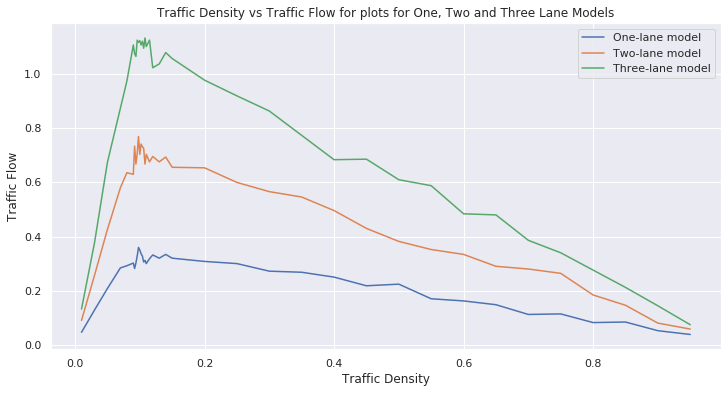

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(one_lane_traffic_density, avg, label = "One-lane model")
plt.plot(two_lane_traffic_density, avg_twolane, label = "Two-lane model")
plt.plot(three_lane_traffic_density, avg_threelane, label = "Three-lane model")
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.legend()
plt.title('Traffic Density vs Traffic Flow for plots for One, Two and Three Lane Models')
plt.show()

### Bad-driving

In [13]:
sim = ThreeLaneTrafficSimulation(slow_down_prob=0.9)
sim.display()
for i in range(30):
    sim.step()  

11.4.0.1.5...4...1....5.2.4.3..53.2......1......30..4...1.5.....4..4......2.....4...54....4....1...0
....40...5.0.23.41.......214.5.....2.3..5.0...32..3.4.......2...1.5......3...0.3..0.0.....3........5
.31.........2...1..44.1.....4.5..3.2..5..15....5...4.....21...1..2..20........2.0.4...2....0..0..0.0

00.0.0.0...2...2...2..0.0.0..1.00...2.....1.....0.1...2.0.....4..1.....4....2.....2.0...3....3..1..0
..3.00....10.00.0.1......000.....4.0...2.10...0.1.0.....4.....2.0.....4....2..1.1.0.0........3......
.0.1..........2..1.00..1....0..1.0..1..1.0...3...2.....4.0.1...1..1.00........0..1..2...2..0..0..0.0

.0.0..10.....2...2..1.0.0.0..0.00.....2....1....0...2.0.0......1..1.......3...2...0.0.......4.1...20
0.0.00....00.00.0..1.....000.....0.0...0.00...0.0.0.........4.0.0........3..1.0..1.10...........3...
10..1..........1.0.00...1...0...10...1..10.....2...2...0.0..1....20.00........0...1...2..1.0..0..0..

.0.0..00........3.1.0.0.0.0..0.00.......2...1...0...0.0..1......1..1........2...2.0.0...

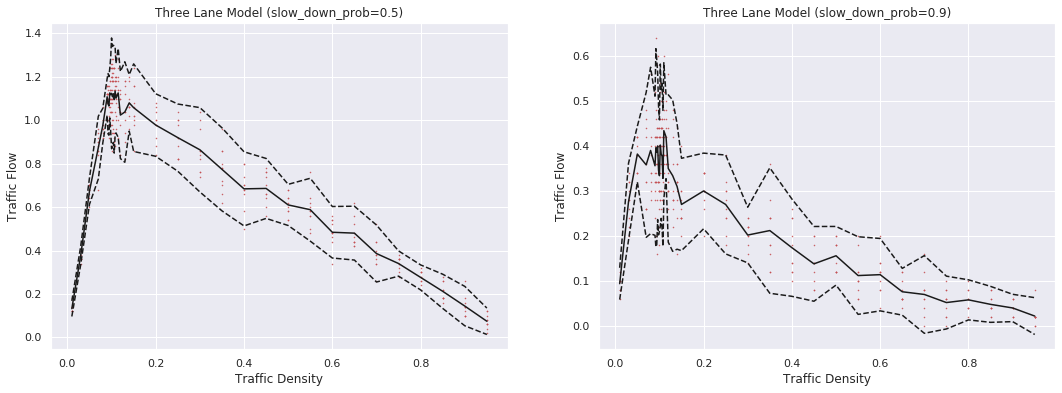

In [16]:
bad_driving_traffic_flow = []
bad_driving_traffic_density = []
for el in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05)
)):
    bad_driving_traffic_density.append(el)
    bad_driving_traffic_flow.append([])
    for run in range(10):
        sim = ThreeLaneTrafficSimulation(car_density=el, slow_down_prob=0.9)
        for i in range(50):
            sim.step(display=False)
        bad_driving_traffic_flow[-1].append(sim.cumulative_traffic_flow / sim.time_step)
        
avg_bad_driving = np.mean(np.array(bad_driving_traffic_flow), axis=1)
std_dev_bad_driving = np.std(np.array(bad_driving_traffic_flow), axis=1)
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.plot(three_lane_traffic_density, three_lane_traffic_flow, 'r.', markersize=1)
plt.plot(three_lane_traffic_density, avg_threelane, 'k-')
plt.plot(three_lane_traffic_density, avg_threelane + 1.96*std_dev_threelane, 'k--')
plt.plot(three_lane_traffic_density, avg_threelane - 1.96*std_dev_threelane, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.title('Three Lane Model (slow_down_prob=0.5)')

plt.subplot(1,2,2)
plt.plot(bad_driving_traffic_density, bad_driving_traffic_flow, 'r.', markersize=1)
plt.plot(bad_driving_traffic_density, avg_bad_driving, 'k-')
plt.plot(bad_driving_traffic_density, avg_bad_driving + 1.96*std_dev_bad_driving, 'k--')
plt.plot(bad_driving_traffic_density, avg_bad_driving - 1.96*std_dev_bad_driving, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Traffic Flow')
plt.title('Three Lane Model (slow_down_prob=0.9)')
plt.show()